#### Analisis
Entrenar un modelo Word2Vec para el español. Se puede utilizar agrupar datasets de "Sophia" en un solo dataset grande.

Entrenar distintos modelos de clasificación de textos, utilizando Word2Vec y sin utilizar Word2Vec, para resolver el problema de clasificación siguiente: reconocer automáticamente el medio qlas noticias según el nombre del medio.

In [1]:
from gensim.models import word2vec
from IPython.display import display, HTML
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression # Log classifier
from sklearn.model_selection import train_test_split # Split in train/test
from sklearn import metrics
import matplotlib.pyplot as plt
import gensim 
import numpy as np
import spacy
from sklearn.model_selection import StratifiedShuffleSplit # for split data (train/test)

In [2]:
# Analize data
df = pd.read_csv('dataset-cuarta_vs_tercera.csv', sep = '|', header = None)

# Get news and medium
df = df.iloc[:,[1,3]]

# display(df.iloc[1,:])

# Get dummies variables
dummies = pd.get_dummies(df[1], drop_first = True)
df = pd.concat([df, dummies], axis=1)      
df.drop([1], inplace=True, axis=1)

# Add names
df.columns = ['report', 'company']

# company:
# 0: La cuarta
# 1: La tercera

df.head()

,report,company
0,Detectamos que JavaScript está desactivado en...,1
1,Detectamos que JavaScript está desactivado en...,1
2,Detectamos que JavaScript está desactivado en...,1
3,"Para los diputados, el informe de auditoría q...",1
4,Ayer se concretó el cierre del primer Centro ...,1


(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

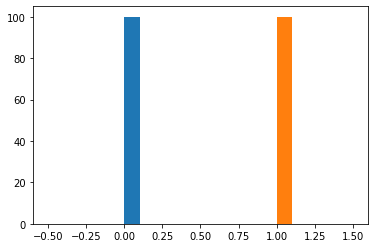

In [3]:
# Distribution of labels
fig, ax = plt.subplots()

# plot hist
ax.hist(df.loc[df['company'] == 0, 'company'], bins = 10)
ax.hist(df.loc[df['company'] == 1, 'company'], bins = 10)

Del gráfico anterior se tiene que las clases estan balanceadas.

In [4]:
# Tokenizer

# Define own tokenizer

nlp = spacy.load('es_core_news_sm')

def own_tokenizer(sentence):
    
    tokens = []
    
    doc = nlp(sentence.lower().strip())
    
    for token in doc:
        
        # Filtering
        if not token.is_space and not token.is_stop and not token.is_punct and not token.is_digit and not token.like_num:
            
            # add token to list in lemma form
            tokens.append(token.lemma_)
            
    return tokens

In [5]:
# Vectorizer

# Bag of words
bow_vector = CountVectorizer(tokenizer = own_tokenizer, ngram_range = (1,1))

# TFIDF
tfidf_vector = TfidfVectorizer(tokenizer = own_tokenizer, ngram_range = (1,1))

In [6]:
# Get data
X = df['report'] # the features we want to analyze
y = df['company'] # the labels, or answers, we want to test against

# Split data in trainig and testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

# Create split data
sss = StratifiedShuffleSplit(n_splits= 1, test_size=0.3, random_state=0)

# Generate index for splitting data
# It get index first becuase it needs the index for word2vec implementation
for train_index, test_index in sss.split(X, y):
    
    # Get index
    train_id_list = train_index
    test_id_list = test_index

# Split data
X_train, X_test = X[train_id_list], X[test_id_list]
y_train, y_test = y[train_id_list], y[test_id_list]

In [7]:
# Create log classifier
log_regr = LogisticRegression()

# Create pipeline
pipe_bow = Pipeline([('preprocessing', bow_vector),
                 ('logistic regression', log_regr)])

pipe_tfidf = Pipeline([('preprocessing', tfidf_vector),
                 ('logistic regression', log_regr)])


In [8]:
# Train model

# Using bag of words embedding
pipe_bow.fit(X_train, y_train)

# Using tfidf word embedding
pipe_tfidf.fit(X_train, y_train)

/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessing',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_p...,
                                 tokenizer=<function own_tokenizer at 0x7f270ac66f28>,
                                 use_idf=True, vocabulary=None)),
                ('regression-LR',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_

In [9]:
# Predicting on test data

# using bag of words embedding
y_predict_bow = pipe_bow.predict(X_test)

# using tfidf embedding
y_predict_tfid = pipe_tfidf.predict(X_test)

In [10]:
print('\nBOW embedding\n')
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, y_predict_bow))
print("Logistic Regression Precision:",metrics.precision_score(y_test, y_predict_bow))
print("Logistic Regression Recall:",metrics.recall_score(y_test, y_predict_bow))
print("Logistic Regression F1 score:",metrics.f1_score(y_test, y_predict_bow))

print('\nTFIDF embedding\n')
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, y_predict_tfid))
print("Logistic Regression Precision:",metrics.precision_score(y_test, y_predict_tfid))
print("Logistic Regression Recall:",metrics.recall_score(y_test, y_predict_tfid))
print("Logistic Regression F1 score:",metrics.f1_score(y_test, y_predict_tfid))



BOW embedding

Logistic Regression Accuracy: 0.75
Logistic Regression Precision: 0.6744186046511628
Logistic Regression Recall: 0.9666666666666667
Logistic Regression F1 score: 0.7945205479452055

TFIDF embedding

Logistic Regression Accuracy: 0.7333333333333333
Logistic Regression Precision: 0.6944444444444444
Logistic Regression Recall: 0.8333333333333334
Logistic Regression F1 score: 0.7575757575757577


# Testing for Word2Vec

In [11]:
# Tokenizer

# Define own tokenizer

nlp = spacy.load('es_core_news_sm')

def own_tokenizer(sentence):
    
    tokens = []
    
    doc = nlp(sentence.lower().strip())
    
    for token in doc:
        
        # Filtering
        if not token.is_space and not token.is_stop and not token.is_punct and not token.is_digit and not token.like_num:
            
            # add token to list in lemma form
            tokens.append(token.lemma_)
            
    return tokens

In [29]:
X_w2v = [ own_tokenizer(report) for report in df['report']]

In [30]:
X_w2v = np.array(X_w2v)

In [32]:
# let X be a list of tokenized texts (i.e. list of lists of tokens)
model_w2v = gensim.models.Word2Vec(X_w2v, size=11)
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.syn0))

/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
class MeanEmbeddingVectorizer(object):
      
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])


In [34]:
pipe_word2vec = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("logistic regression", LogisticRegression())])

In [35]:
# Get X train and test

# Get train data
X_w2v_train = X_w2v[train_id_list]
y_w2v_train = df['company'][train_id_list]

# Get test data
X_w2v_test = X_w2v[test_id_list]
y_w2v_test = df['company'][test_id_list]

In [36]:
pipe_word2vec.fit(X_w2v_train, y_w2v_train)

/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('word2vec vectorizer',
                 <__main__.MeanEmbeddingVectorizer object at 0x7f26f7f9d5f8>),
                ('logistic regression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [45]:
y_predict_w2v = pipe_word2vec.predict(X_w2v_test)

In [46]:
print('\nWord2Vec embedding:\n')
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, y_predict_w2v))
print("Logistic Regression Precision:",metrics.precision_score(y_test, y_predict_w2v))
print("Logistic Regression Recall:",metrics.recall_score(y_test, y_predict_w2v))
print("Logistic Regression F1 score:",metrics.f1_score(y_test, y_predict_w2v))


Word2Vec embedding:

Logistic Regression Accuracy: 0.6333333333333333
Logistic Regression Precision: 0.6333333333333333
Logistic Regression Recall: 0.6333333333333333
Logistic Regression F1 score: 0.6333333333333333
